In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 5
fig_height = 4
fig_format = 'png'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'':
  os.chdir(r'')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/tmp/ipykernel_3706502/4078108651.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/usr/lib/python3.8/importlib/_bootstrap.py": 1650335526.0, "/usr/lib/python3.8/importlib/_bootstrap_external.py": 1650335526.0, "/usr/lib/python3.8/codecs.py": 1650335526.0, "/usr/lib/python3.8/encodings/aliases.py": 1650335526.0, "/usr/lib/python3.8/encodings/__init__.py": 1650335526.0, "/usr/lib/python3.8/encodings/utf_8.py": 1650335526.0, "/usr/lib/python3.8/encodings/latin_1.py": 1650335526.0, "/usr/lib/python3.8/abc.py": 1650335526.0, "/usr/lib/python3.8/io.py": 1650335526.0, "/usr/lib/python3.8/stat.py": 1650335526.0, "/usr/lib/python3.8/_collections_abc.py": 1650335526.0, "/usr/lib/python3.8/genericpath.py": 1650335526.0, "/usr/lib/python3.8/posixpath.py": 1650335526.0, "/usr/lib/python3.8/os.py": 1650335526.0, "/usr/lib/python3.8/_sitebuiltins.py": 1650335526.0, "/usr/lib/python3.8/_bootlocale.py": 1650335526.0, "/usr/lib/python3.8/types.py": 1650335526.0, "/usr/lib/python3.8/warnings.py": 1650335526.0, "/usr/lib/python3.8/importlib/__init__.py": 1650335526.0, "/usr/lib/pytho

In [2]:
#| include: false
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200

seed_value=123
import random
import tensorflow as tf
import numpy as np
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
#| eval: false
import urllib.request
from zipfile import ZipFile

urllib.request.urlretrieve(
    "https://zenodo.org/record/6824173/files/data.zip?download=1",
    "data.zip",
)

ZipFile("data.zip", "r").extractall(".")

In [4]:
# We'll be working with our data primarily as pandas DataFrames
# and converting them to numpy arrays as necessary:
import numpy as np
import pandas as pd

# We'll set a random number seed 
# to ensure reproducibility across notebook runs.
#
# First, set the environment variable 'PYTHONHASHSEED' to 0:
import os
os.environ['PYTHONHASHSEED']=str(0)

# Now, set the random seeds from the `random` and `numpy` packages:
import random
random.seed(123)
np.random.seed(123)

# We'll use scikit-learn for normalizing our data,
# and for splitting our data into training-validation-testing sets:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# We'll use Keras, installed as part of Tensorflow, for model fitting:
import tensorflow as tf
from tensorflow import keras

# Set one more random seed value, this time from Tensorflow itself:
tf.random.set_seed(123)

# Initialize our GPUs to use memory growth, in order to work better
# when multiple jobs are using the same GPU
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
full_data = pd.read_csv("data/3_county.csv")
full_labels = full_data.pop("shrub")

In [6]:
print(full_data.iloc[:, 0:6].head(n=5))

         x        y  lcsec_2014  tcb_2014  tcw_2014  tcg_2014
0  1788750  2339280           4      2995      -638      2642
1  1788780  2339280           3      2759      -487      2437
2  1788480  2339250           1      2655      -634      2259
3  1788510  2339250           4      2908      -720      2253
4  1788720  2339250           4      3153      -698      2726


In [7]:
full_data = pd.concat(
    [
        full_data,
        pd.get_dummies(full_data["lcsec_2014"], prefix="lcsec", drop_first=True),
    ],
    axis=1,
)
print(full_data.iloc[:, 16:23].head(n=5))

   lcsec_2  lcsec_3  lcsec_4  lcsec_5  lcsec_6  lcsec_8
0        0        0        1        0        0        0
1        0        1        0        0        0        0
2        0        0        0        0        0        0
3        0        0        1        0        0        0
4        0        0        1        0        0        0


In [8]:
full_features = full_data.drop(["lcsec_2014", "x", "y"], axis=1)

print(full_features.iloc[:, 0:6].head(n=5))

   tcb_2014  tcw_2014  tcg_2014  nbr_2014  mag_2014  yod_2014
0      2995      -638      2642       737         0         0
1      2759      -487      2437       750         0         0
2      2655      -634      2259       708         0         0
3      2908      -720      2253       678         0         0
4      3153      -698      2726       742         0         0


In [9]:
[train_features, test_features, train_labels, test_labels] = train_test_split(
    full_features, full_labels, test_size=0.2, random_state=123, stratify=full_labels
)

In [10]:
[
    train_features,
    validation_features,
    train_labels,
    validation_labels,
] = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=123, stratify=train_labels
)

In [11]:
train_features = np.array(train_features)
validation_features = np.array(validation_features)
test_features = np.array(test_features)

In [12]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

In [13]:
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

In [14]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    .batch(64)
    .prefetch(2)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))
    .batch(64)
    .prefetch(2)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    .batch(64)
    .prefetch(2)
)

In [15]:
neg, pos = np.bincount(train_labels)
total = neg + pos
print(
    "Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n".format(
        total, pos, 100 * pos / total
    )
)

Examples:
    Total: 4585730
    Positive: 70213 (1.53% of total)



In [16]:
class_weight = {
    0: (1 / neg) * (total / 2.0), 
    1: (1 / pos) * (total / 2.0)
}
class_weight

{0: 0.5077746357726036, 1: 32.65584720778204}

In [17]:
metrics = [
    keras.metrics.TruePositives(name="True_Positives"),
    keras.metrics.FalsePositives(name="False_Positives"),
    keras.metrics.TrueNegatives(name="True_Negatives"),
    keras.metrics.FalseNegatives(name="False_Negatives"),
    keras.metrics.BinaryAccuracy(name="Binary_Accuracy"),
    keras.metrics.Precision(name="Precision"),
    keras.metrics.Recall(name="Recall"),
    keras.metrics.AUC(name="AUC"),
    keras.metrics.AUC(name="PRC", curve="PR"),
]

In [18]:
def make_model(metrics=metrics):
    # Create a model object using the sequential API:
    model = keras.Sequential(
        [
            # Add a dense layer, using:
            # + 256 neurons
            # + The rectified linear unit ("ReLU") activation function
            # + An input layer with the same number of neurons
            #   as predictors in our training data
            keras.layers.Dense(
                256, activation="relu", input_shape=(train_features.shape[-1],)
            ),
            # Add another dense layer, this time with 128 neurons:
            keras.layers.Dense(
                128, activation="relu"),
            # Another with 64:
            keras.layers.Dense(
                64, activation="relu"),
            # Another with 32:
            keras.layers.Dense(
                32, activation="relu"),
            # And another with 16:
            keras.layers.Dense(
                16, activation="relu"),
            # Add a dropout layer.
            # This will randomly set 20% of the inputs -- 
            # -- that is, the outputs from the last dense layer --
            # to 0, which helps protect against overfitting
            keras.layers.Dropout(0.2),
            # Finally, add a dense layer with a single neuron,
            # using the "sigmoid" activation function
            # 
            # This will produce our final probability predictions
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        # Use "Adaptive Moment Estimation" optimization to tune weights
        #
        # This algorithm will adjust the weights of each neuron in
        # the network every epoch, attempting to optimize the loss function
        # defined in the next argument
        #
        # While the details are somewhat complicated, for applied purposes
        # it's often practical to just use the Adam optimizer with a rather 
        # small "learning rate" to achieve a decent model
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        # Use the most standard loss for binary classification models,
        # binary cross-entropy, to judge how well our model is doing.
        #
        # Lower cross-entropy values are better.
        loss=keras.losses.BinaryCrossentropy(name="Binary_Cross_Entropy"),
        # In addition to calculating our cross-entropy loss at each step
        # and adjusting our model weights, we'll also ask Keras to calculate
        # the metrics we defined earlier for every epoch
        metrics=metrics,
    )
    return model

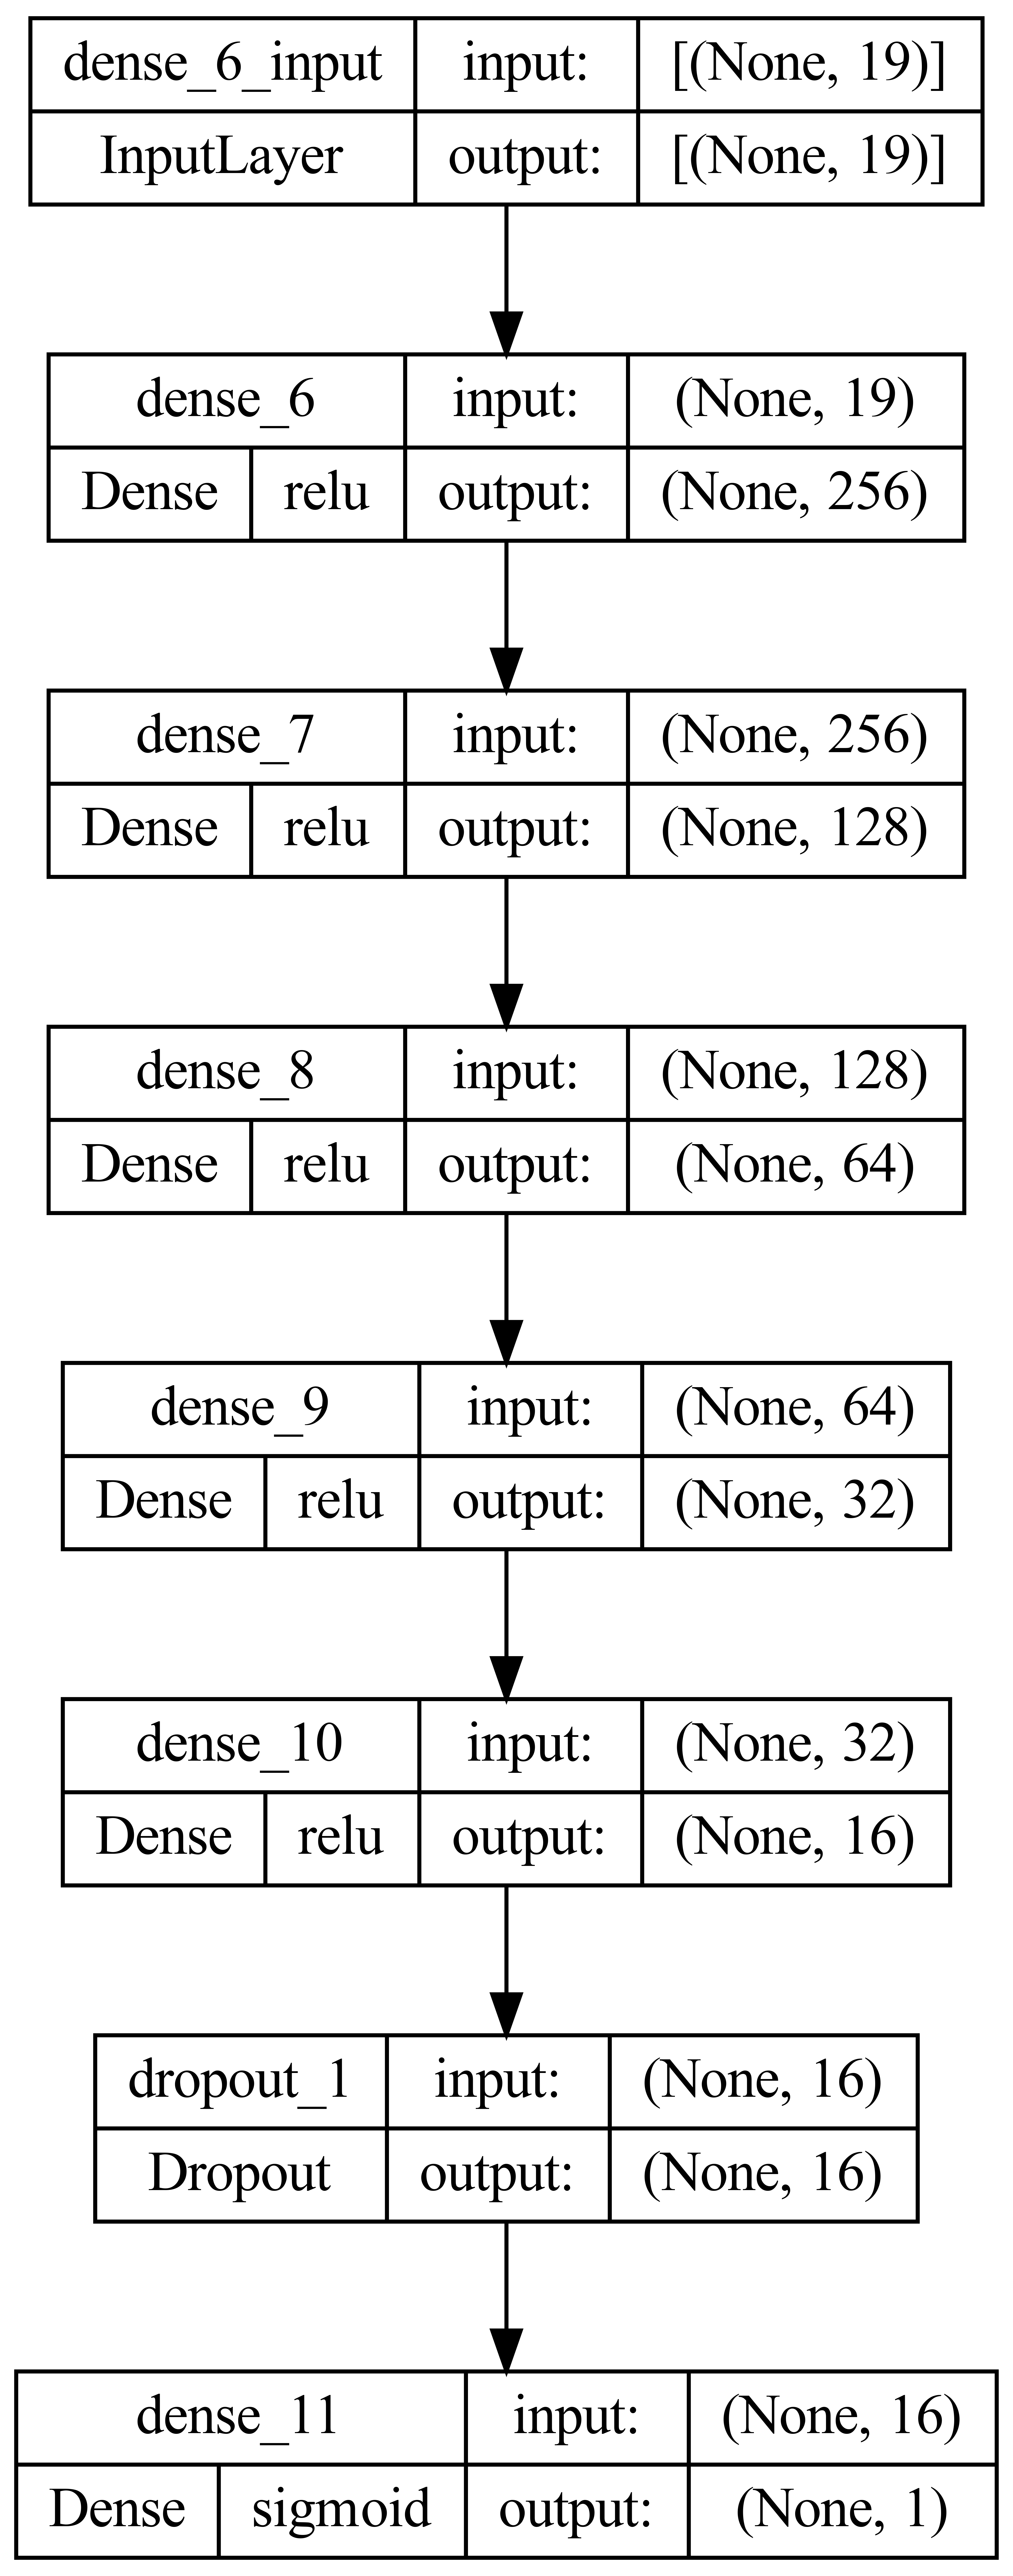

In [19]:
#| label: fig-model
#| fig-cap: A schematic showing the structure of our neural network.
shrubland_model = make_model()

keras.utils.plot_model(
  shrubland_model, show_shapes=True, show_layer_activations=True, dpi=1200
)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_PRC", verbose=1, patience=10, mode="max", restore_best_weights=True
)

In [21]:
resampled_history = shrubland_model.fit(
    train_ds,
    steps_per_epoch=20,
    epochs=1000,
    callbacks=[early_stopping],
    validation_data=(val_ds),
    class_weight=class_weight,
    verbose=0,
)

Restoring model weights from the end of the best epoch: 49.


Epoch 59: early stopping


In [22]:
#| echo: false
from IPython.display import display, Markdown

tot_epoch = len(resampled_history.history["loss"])
stop_epoch = tot_epoch - 10

display(Markdown("""
It appears that our model's PRC score stops improving after {stop_epoch} epochs, which due to our "patience" value of 10 causes our early stopping rules to kick in after epoch {tot_epoch}. We can visualize this process by plotting the PRC values from each epoch of model training, using the `resampled_history` object returned from the fitting process:
""".format(tot_epoch=tot_epoch, stop_epoch=stop_epoch)))


It appears that our model's PRC score stops improving after 49 epochs, which due to our "patience" value of 10 causes our early stopping rules to kick in after epoch 59. We can visualize this process by plotting the PRC values from each epoch of model training, using the `resampled_history` object returned from the fitting process:


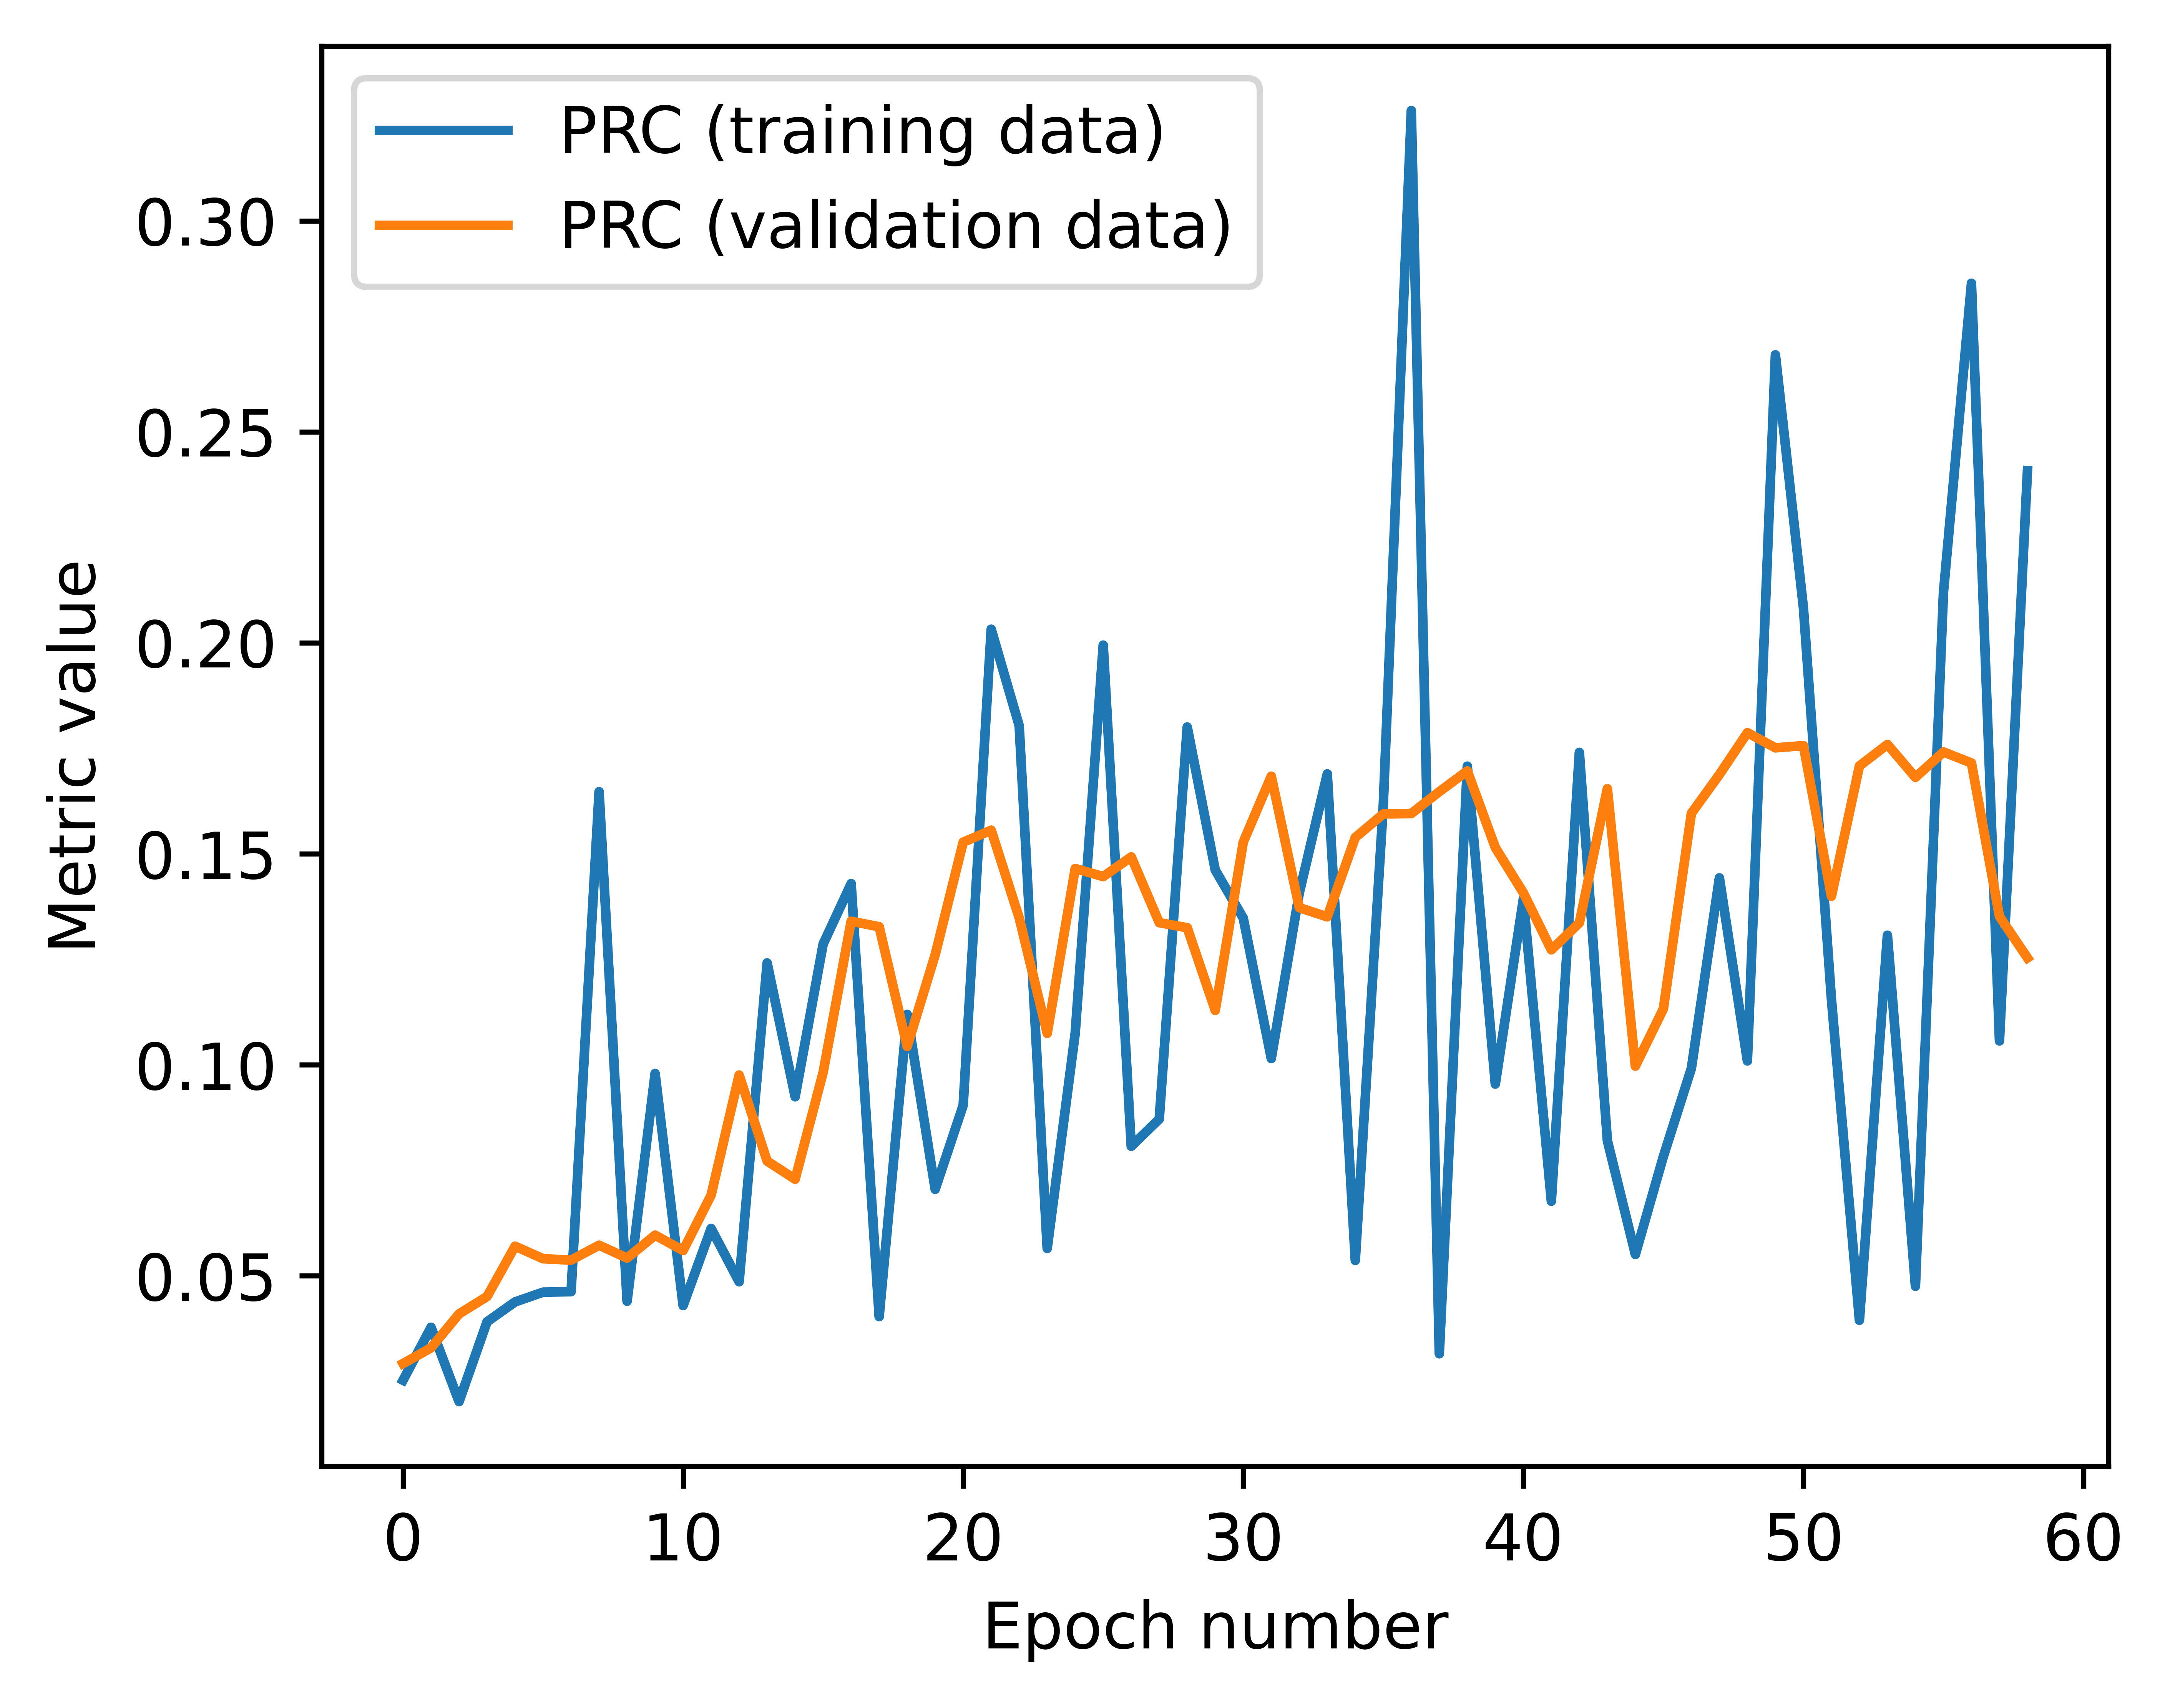

In [23]:
#| label: fig-training
#| fig-cap: Precision-recall curve (PRC) at each epoch of model training. Higher PRC values indicate a better classifier.
import matplotlib.pyplot as plt

plt.plot(resampled_history.history["PRC"], label="PRC (training data)")
plt.plot(resampled_history.history["val_PRC"], label="PRC (validation data)")
plt.ylabel("Metric value")
plt.xlabel("Epoch number")
plt.legend(loc="upper left")
plt.show()

In [24]:
#| echo: false
display(Markdown("""
It appears that, even though our highest PRC score was achieved after {stop_epoch} epochs, we might have achieved even higher PRC values had early stopping not kicked in. 

For the purposes of this tutorial, we're going to continue using the model produced after {stop_epoch} epochs. Later, as part of the Assignment section of the chapter, you might want to try other parameters in the early stopping function to see if you can improve the performance of the model.

## Model Evaluation

And just like that, we have a neural net trained to identify shrubland! Now that our model is fully trained (after {stop_epoch} epochs), the next step is to evaluate it against our hold-out test data frame. We can use the `evaluate()` method of our model object to do so:
""".format(stop_epoch=stop_epoch)))


It appears that, even though our highest PRC score was achieved after 49 epochs, we might have achieved even higher PRC values had early stopping not kicked in. 

For the purposes of this tutorial, we're going to continue using the model produced after 49 epochs. Later, as part of the Assignment section of the chapter, you might want to try other parameters in the early stopping function to see if you can improve the performance of the model.

## Model Evaluation

And just like that, we have a neural net trained to identify shrubland! Now that our model is fully trained (after 49 epochs), the next step is to evaluate it against our hold-out test data frame. We can use the `evaluate()` method of our model object to do so:


In [25]:
results = shrubland_model.evaluate(test_ds, verbose=0)

for name, value in zip(shrubland_model.metrics_names, results):
    print(name, ": ", value)
print()

loss :  0.4313044250011444
True_Positives :  19575.0
False_Positives :  424301.0
True_Negatives :  986799.0
False_Negatives :  2366.0
Binary_Accuracy :  0.7022646069526672
Precision :  0.04410015419125557
Recall :  0.8921653628349304
AUC :  0.8874118328094482
PRC :  0.1810697615146637



In [26]:
full_array = np.array(full_features)
full_array = scaler.transform(full_array)

full_ds = tf.data.Dataset.from_tensor_slices((full_array, full_labels)).cache()
full_ds = full_ds.batch(64).prefetch(2)

In [27]:
predictions = pd.DataFrame(shrubland_model.predict(full_ds, verbose=0))

full_data = pd.concat(
    [full_data, predictions],
    axis=1,
)

In [28]:
location_predictions = full_data[["x", "y", 0]]
location_predictions.columns = ["x", "y", "z"]

In [29]:
import rasterio
from affine import Affine

In [30]:
xmin = location_predictions["x"].min()
xmax = location_predictions["x"].max()
ymin = location_predictions["y"].min()
ymax = location_predictions["y"].max()

In [31]:
# Resolution of our Landsat-derived predictors:
# Each observation represents a 30-meter square "pixel" of the map
pixel_size = 30

# Identify the X and Y values for each pixel in our output raster
xv = pd.Series(np.arange(xmin, xmax + pixel_size, pixel_size))
yv = pd.Series(np.arange(ymin, ymax + pixel_size, pixel_size)[::-1])

# Get the X and Y cell indices for each of these pixels
xi = pd.Series(xv.index.values, index=xv)
yi = pd.Series(yv.index.values, index=yv)

In [32]:
# Create an empty array of the proper size for our data:
nodata = -9999.0
zv = np.ones((len(yi), len(xi)), np.float32) * nodata

# Fill in the array with our predicted values, wherever they exist:
zv[
    yi[location_predictions["y"]].values, xi[location_predictions["x"]].values
] = location_predictions["z"]

In [33]:
transform = Affine(pixel_size, 0, xmin, 0, -pixel_size, ymax) * Affine.translation(
    -0.5, -0.5
)

In [34]:
# This is the PROJ string for the raster data used in this study
# It represents how to associate the X and Y coordinates with real world data
projection = "+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5"
projection = projection + " +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

with rasterio.open(
    # Our output file name
    "predictions.tiff",
    # What mode to open the file in -- here, write mode
    "w",
    # What driver to use to write our file
    "GTiff",
    # Number of columns to write
    len(xi),
    # Number of rows to write
    len(yi),
    # How many "bands" to write
    1,
    projection,
    # The transformation created above
    transform,
    # What data type to save as
    rasterio.float32,
    # What value indicates a missing value
    nodata,
) as ds:
    ds.write(zv.astype(np.float32), 1)

In [35]:
#| echo: false
auc = round(results[-2] * 100)
display(Markdown("""
In that situation, our model would give the right results {auc}% of the time, which makes it a highly effective classifier. However, given that only 1.5% of our region is shrubland, the scenario described by AUC isn't a great representation of how our model actually performs on the ground.
""".format(auc=auc)))


In that situation, our model would give the right results 89% of the time, which makes it a highly effective classifier. However, given that only 1.5% of our region is shrubland, the scenario described by AUC isn't a great representation of how our model actually performs on the ground.


In [36]:
test_predictions = pd.DataFrame(shrubland_model.predict(test_ds, verbose=0))

import statistics

statistics.mean(test_labels.loc[np.array(test_predictions[0] > 0.9)])

0.2394189044714169

In [37]:
statistics.mean(test_labels.loc[np.array(test_predictions[0] > 0.95)])

0.5160095263297169